# Universal Path Decomposition of Multilayer Transfer and Scattering Matrices


## Geophysics/Seismology Example

**Companion** to the homonymous paper by *Joaquin Garcia-Suarez* (2025)


This notebook provides an interactive implementation of the concepts introduced in the paper. The parameters are chosen to generate the results in Figure ?? of the main text.

---


### Parsing Layered Earth Model Data from Kik-Net

This snippet processes seismic velocity data from a Kik-Net site profile (station code: `fksh14`) typically used in geotechnical and seismological analysis. The raw data describes subsurface layers, including shear wave velocity (Vs) and compressional wave velocity (Vp), along with depth and thickness.

---

### Raw Input Format

Each line in `raw_data` contains:

- **Layer number**
- **Thickness** (m)
- **Depth** (m)
- **Vp**: P-wave velocity (m/s)
- **Vs**: S-wave velocity (m/s)

The last line represents a **half-space**, an infinite depth region where thickness and depth are not defined (`-----`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import differential_evolution


# Raw text data (from Kik-Net site fksh14)
# No Thickness   Depth    Vp       Vs
#       (m)       (m)    (m/s)    (m/s)
raw_data = """
1,    2.00,    2.00,  500.00,  120.00
2,    6.00,    8.00, 1410.00,  190.00
3,   44.00,   52.00, 1410.00,  280.00
4,   54.00,  106.00, 2210.00, 1030.00
5,   -----,   -----, 2740.00, 1210.00
"""

---

### Step-by-Step Processing

#### 1. **Parsing Lines**
- If the line corresponds to the **half-space** (detected via `-----`), `thickness` and `depth` are set to `None`.
- All valid numeric values are cast to `float` and appended as tuples to the `layers` list.

#### 2. **Converting to NumPy Arrays**
- Arrays for `thicknesses` and `depths` are built **excluding the half-space** (i.e., all but the last layer).
- Arrays for `vp` and `vs` include **all layers**, including the half-space.
- The **half-space values** are extracted separately as `vp_half` and `vs_half`.

---

### Outputs

- `thicknesses`: Array of thicknesses for all finite layers.
- `depths`: Array of depths for all finite layers.
- `vp`: Full array of compressional wave velocities.
- `vs`: Full array of shear wave velocities.
- `vp_half`, `vs_half`: P- and S-wave velocities for the half-space layer.

In [2]:
# Step 1: Parse the lines
layers = []
for line in raw_data.strip().split('\n'):
    parts = [p.strip() for p in line.split(',')]
    if '-----' in parts[1]:  # half-space
        thickness = None
        depth = None
    else:
        thickness = float(parts[1])
        depth = float(parts[2])
    vp = float(parts[3])
    vs = float(parts[4])
    layers.append((thickness, depth, vp, vs))

# Step 2: Convert to arrays
thicknesses = np.array([l[0] for l in layers[:-1]])  # exclude half-space
depths      = np.array([l[1] for l in layers[:-1]])
vp          = np.array([l[2] for l in layers])
vs          = np.array([l[3] for l in layers])

# Last layer is half-space
vp_half = vp[-1]
vs_half = vs[-1]

### Plotting the Shear Wave Velocity ($V_s$) Depth Profile

This snippet creates a **step plot** to visualize the shear wave velocity ($V_s$) as a function of depth, which is a common way to represent 1D layered velocity models in geotechnical and seismological studies.

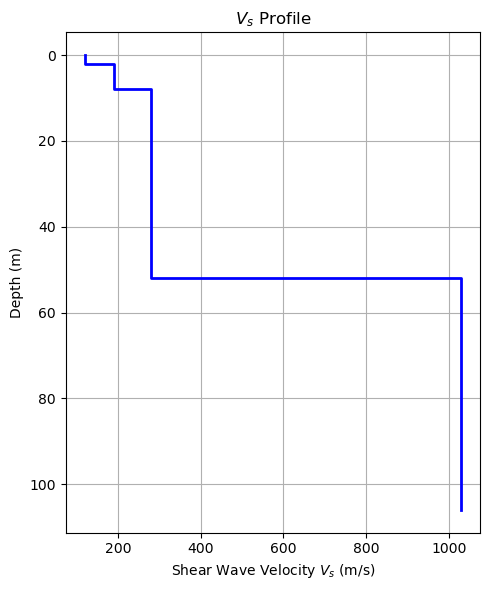

In [3]:
# Build depth profile (start and end of each layer)
depth_edges = np.concatenate(([0], depths))  # top of first to bottom of last
vs_steps = np.repeat(vs[:-1], 2)             # repeat each value to make step plot
depth_steps = np.repeat(depth_edges, 2)[1:-1]  # remove outermost point

# Plot
plt.figure(figsize=(5, 6))
plt.plot(vs_steps, depth_steps, drawstyle='steps-post', color='blue', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel('Shear Wave Velocity $V_s$ (m/s)')
plt.ylabel('Depth (m)')
plt.title('$V_s$ Profile')
plt.grid(True)
plt.tight_layout()
plt.show()


## Frequency Response via Transfer Matrix Method

This code computes the **frequency-dependent site response** using the **transfer matrix method** for a 1D layered soil profile over a half-space. It evaluates how vertically incident shear waves are modified as they travel upward through the layers to the surface.

---

### Setup

- `NN`: Number of finite layers (excluding the half-space).
- `DE`: Damping ratio applied uniformly across all layers.
- `rho`: Array of densities for each layer (1500 kg/m³ for simplicity).
- `freqs`: Frequency range from 0.1 Hz to 20 Hz, sampled at 400 points.
- `omega_array`: Angular frequencies, $\omega = 2\pi f$.

---

### Transfer Matrix for a Single Layer

The function `T_layer` computes the **transfer matrix** for a single viscoelastic layer given:

- `vs`: Shear wave velocity.
- `h`: Layer thickness.
- `omega`: Angular frequency (complex, due to damping).
- `rho`: Density.

The matrix:

$$
T =
\begin{bmatrix}
\cos(kh) & \dfrac{\sin(kh)}{Z} \\
-Z \sin(kh) & \cos(kh)
\end{bmatrix}
$$

where:

- $k = \omega / v_s$ is the wavenumber,
- $Z = \rho v_s$ is the shear impedance.

---

### Frequency Loop: Full Transfer Matrix

For each frequency:

- Initialize total transfer matrix $T$ as identity.
- Loop from **bedrock to surface** (bottom-up), multiplying each layer's transfer matrix `Ti`.
- Complex frequency is adjusted for damping: $\omega (1 - i D/2)$.
- After combining all layers, extract $T_{11}$ — the top-left element of the final transfer matrix — which corresponds to **surface response to bedrock motion** under vertically incident SH waves (we ignore radiational damping effects).

In [4]:
NN = len(thicknesses)
DE = 2*0.05 # damping, same for all layers
rho = np.ones(NN)*1500 #density of each layer
freqs = np.linspace(0.1, 20.0, 400)
omega_array = 2 * np.pi * freqs

# Transfer matrix for a single layer
def T_layer(vs, h, omega, rho):
    k = omega / vs
    Z = rho * vs
    cos_kh = np.cos(k * h)
    sin_kh = np.sin(k * h)
    return np.array([
        [cos_kh,       sin_kh / Z],
        [-Z * sin_kh,  cos_kh]
    ])

# Compute full transfer matrix from bedrock to surface
T11_values = []

for omega in omega_array:
    T = np.identity(2)
    for i in range(NN):  # from bedrock upward
        Ti = T_layer(vs[i], thicknesses[i], omega*(1-DE*1j/2), rho[i])
        T = Ti @ T  # matrix product: top layer * below
    T11_values.append(T[0, 0])  # surface response to bedrock motion

T11_values = np.array(T11_values)


## Frequency Response via Path Decomposition

### Generating Sign Paths with a Reflection Limit

This function `generate_paths_with_max_reflections` creates all possible **paths** through a layered medium, with an optional limit on the number of internal reflections allowed.

---

### Function: `generate_paths_with_max_reflections(NN, M=None)`

- **Parameters**:
  - `NN`: Number of layers (including the source and receiver sides).
  - `M` (optional): Maximum number of internal reflections allowed. Defaults to `NN - 1`, which includes **all possible** paths.

- **Returns**:
  - A NumPy array of shape $(P, NN)$, where each row is a sign path (±1 values) indicating the **direction of wave travel** at each interface.

---

### Description

- `positions = range(1, NN)` defines the possible **flip points** between layers (excluding the starting point).
- For each number of reflections $r = 0$ to $M$, the function generates all combinations of $r$ flip positions.
- Each path `p` starts at +1 and flips sign at the specified positions.

Example for `NN = 4` and `M = 1`:
- Reflections = 0:
  - `[+1, +1, +1, +1]`
- Reflections = 1:
  - `[+1, -1, -1, -1]`
  - `[+1, +1, -1, -1]`
  - `[+1, +1, +1, -1]`

---

### Notes

- The total number of generated paths grows combinatorially with `M` and `NN`, so choosing a small `M` can **significantly reduce computation** for large models.
- Paths with more reflections contribute to higher-order interference effects but may be less significant depending on frequency or damping.

In [5]:
def generate_paths_with_max_reflections(NN, M=None):
    from itertools import combinations
    paths = []
    positions = list(range(1, NN))

    max_reflections = M if M is not None else NN - 1
    for r in range(max_reflections + 1):
        for flips in combinations(positions, r):
            p = np.ones(NN, dtype=int)
            sign = 1
            for i in range(1, NN):
                if i in flips:
                    sign *= -1
                p[i] = sign
            paths.append(p)
    return np.array(paths)

### Path-Based Amplitude and Delay Estimation (with Reflection Truncation)

This code evaluates **wave amplitudes and travel-time delays** through a layered medium using a truncated set of **paths**, generated by limiting the number of internal reflections. It forms a compact and efficient approximation of the wave response by considering only dominant interference paths.

---

### Assumptions
- `NN`: Number of finite layers.
- `vs`: Shear wave velocity array of length NN + 1.
- `thicknesses`: Array of length NN (finite layers only).
- `paths_array`: Generated using `generate_paths_with_max_reflections(NN, M)`, meaning paths include up to M internal reflections.

In [6]:
# Generate paths with ≤ M reflections (or all if M is None)
paths_array = generate_paths_with_max_reflections(NN, 3)


NN = len(thicknesses) 

# Step 1: compute ratios at NN-1 interfaces
ratios = (vs[:NN-1] / vs[1:NN])  

# Step 2: prepare path products
p1 = paths_array[:, :-1]  
p2 = paths_array[:, 1:]   

# Step 3: broadcast properly
interface_terms = 0.5 * (1 + p1 * p2 * ratios[np.newaxis, :])  
amplitudes_array = np.prod(interface_terms, axis=1)        
path_delays_array = (paths_array * (thicknesses / vs[:NN])).sum(axis=1)

print(f"Paths created: {len(paths_array):.1f} out of {(2**(NN-1)):.1f}")

# T11(f) ≈ sum_p A_p * cos(ω * τ_p)
omega_array = 2 * np.pi * freqs
phases = np.outer(omega_array*(1-DE*1j/2), path_delays_array)
path_contribs = amplitudes_array * np.cos(phases)
T11_path = path_contribs.sum(axis=1)

Paths created: 8.0 out of 8.0


### Visual comparison

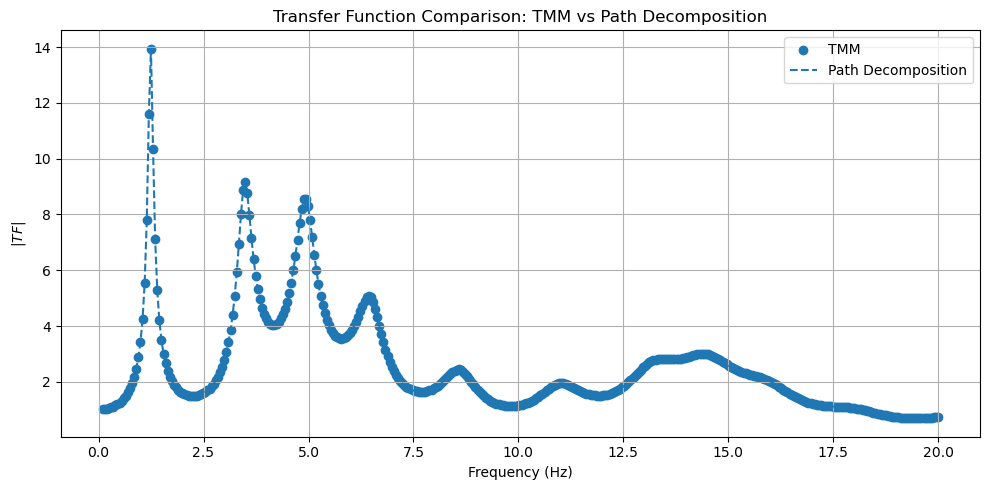

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(freqs, np.abs(1/T11_values), label='TMM')
plt.plot(freqs, np.abs(1/T11_path), label='Path Decomposition', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$|TF|$')
plt.title('Transfer Function Comparison: TMM vs Path Decomposition')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Comparing Full Transfer Matrix Method (TMM) vs. Path Decomposition (Truncated Reflections)

This block visualizes how well **truncated path decomposition** (limited to a maximum number of internal reflections $M$) approximates the **full TMM-based frequency response** of a layered medium.

Paths created for M=0: 1.0 / 8.0
Paths created for M=1: 4.0 / 8.0
Paths created for M=2: 7.0 / 8.0
Paths created for M=3: 8.0 / 8.0


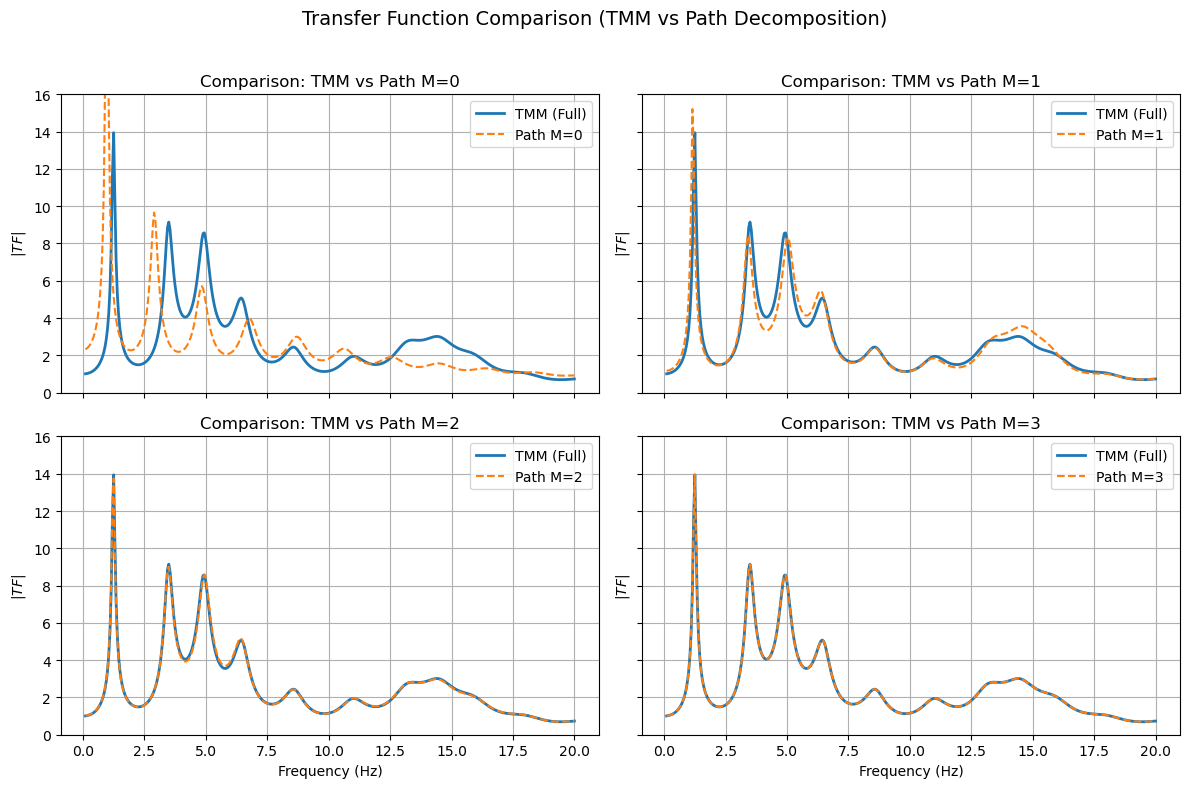

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()  # easier indexing

for M in range(4):  # M = 0 to 3
    ax = axes[M]
    
    paths_array = generate_paths_with_max_reflections(NN, M)

    # Prepare path products
    p1 = paths_array[:, :-1]
    p2 = paths_array[:, 1:]

    interface_terms = 0.5 * (1 + p1 * p2 * ratios[np.newaxis, :])
    amplitudes_array = np.prod(interface_terms, axis=1)
    path_delays_array = (paths_array * (thicknesses / vs[:NN])).sum(axis=1)

    print(f"Paths created for M={M}: {len(paths_array):.1f} / {2**(NN-1):.1f}")

    phases = np.outer(omega_array * (1 - DE * 1j / 2), path_delays_array)
    path_contribs = amplitudes_array * np.cos(phases)
    T11_path = path_contribs.sum(axis=1)

    # Plot TMM and path-based result
    ax.plot(freqs, np.abs(1 / T11_values), label='TMM (Full)', linewidth=2)
    ax.plot(freqs, np.abs(1 / T11_path), label=f'Path M={M}', linestyle='--')

    ax.set_title(f'Comparison: TMM vs Path M={M}')
    ax.set_ylabel(r'$|TF|$')
    ax.grid(True)
    ax.set_ylim(0, 16)
    if M in [2, 3]:
        ax.set_xlabel('Frequency (Hz)')
    ax.legend()

plt.suptitle('Transfer Function Comparison (TMM vs Path Decomposition)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


We acknowledge that the keeping **1 reflection** (4 paths) is enough to predicts all the dominant peaks, while keeping **2 reflections** (7 paths) yields virtually the same result.

# Inverse Problem

### Synthetic "Measured" Transfer Function from True $V_s$ Profile

This section simulates a **synthetic transfer function** based on a known, true shear wave velocity profile. This emulates the kind of data one might obtain from site response measurements, useful for validating inversion techniques.

---
### Function: `compute_T11(vs_profile)`

This function computes the **frequency-dependent transfer function** from bedrock to surface using the **full Transfer Matrix Method (TMM)** for a given shear wave velocity profile.

---

### Purpose

To evaluate the **surface response** of a 1D layered system subjected to vertically incident SH waves by computing the magnitude of the transfer function $|T_{11}|$ over a range of frequencies.

---

### Parameters

- `vs_profile`: 1D array of shear wave velocities for the finite layers (length = `NN`).
- `omega_array`: Global array of angular frequencies $\omega = 2\pi f$.
- `thicknesses`: Array of layer thicknesses (length = `NN`).
- `rho`: Array of layer densities (length = `NN`).
- `DE`: Damping ratio (uniform across layers).

---

### Output

- A 1D array containing $|T_{11}|$ at each frequency — the **amplitude of the surface motion** relative to the input motion at the base of the profile.

In [9]:
# True Vs profile (used for synthetic "measured" data)
true_vs = vs

# --- Full TMM from bedrock to surface ---
def compute_T11(vs_profile):
    T11 = []
    for omega in omega_array:
        T = np.identity(2)
        for i in range(NN):
            Ti = T_layer(vs_profile[i], thicknesses[i], omega * (1 - DE * 1j / 2), rho[i])
            T = Ti @ T
        T11.append(T[0, 0])
    return np.abs(T11)

Evaluate the function to obtain synthetic data

In [10]:
# Generate synthetic transfer function
T11_measured = compute_T11(true_vs)

## Inversion of Shear‐Wave Velocity Profile via Differential Evolution

This block of code performs a **site‐response inversion** to estimate the unknown shear‐wave velocities in a multi‐layer profile, using the measured transfer function as target data. We use **Differential_Evolution**, a global optimization method suitable for non-convex spaces, first using TMM for the forward evaluations, then using paths.

In [11]:
# --- Objective Function for Inversion ---
# We aim to estimate the shear wave velocity profile (Vs) of a layered medium
# by minimizing the misfit between the "measured" (synthetic) and modeled transfer functions.
# Only Vs[1:] is optimized; the topmost Vs value (known_vs0) is fixed.

def objective_function(vs_rest):
    # Reconstruct full Vs profile: fix top layer velocity, optimize the rest
    vs_trial = np.concatenate(([known_vs0], vs_rest))
    
    # Compute modeled transfer function using TMM
    T11_trial = compute_T11(vs_trial)
    
    # Misfit = sum of squared differences between measured and trial response
    return np.sum((T11_trial - T11_measured)**2)


# --- Inversion Settings ---
# Fix the shear wave velocity in the first layer (assumed known a priori)
known_vs0 = vs[0]

# Define bounds for the remaining layers: uniform bounds [100, 2000] m/s
bounds = [(100, 2000)] * (NN - 1)  # NN is number of layers excluding the half-space

# --- Run Differential Evolution Optimization ---
# Differential evolution is a global optimization method suitable for non-convex spaces

start = time.time()

# First run: 25 iterations, moderate population size, no final polishing
result = differential_evolution(
    objective_function,
    bounds,
    maxiter=25,
    popsize=10,
    disp=True,
    polish=False
)

end = time.time()

# Optional second pass: refined search (could be omitted or adjusted)
result = differential_evolution(
    objective_function,
    bounds,
    maxiter=20,
    popsize=10,
    polish=False
)

# Combine known Vs[0] with optimized Vs[1:]
vs_estimated_TMM = np.concatenate(([known_vs0], result.x))

t_inversion_TMM = end - start
print(f"Inversion time: {t_inversion_TMM:.4f} seconds")


# --- Compute Modeled Response for Estimated Profile ---
T11_best = compute_T11(vs_estimated_TMM)

differential_evolution step 1: f(x)= 25.1916
differential_evolution step 2: f(x)= 25.1916
differential_evolution step 3: f(x)= 22.4272
differential_evolution step 4: f(x)= 22.4272
differential_evolution step 5: f(x)= 22.4272
differential_evolution step 6: f(x)= 16.2482
differential_evolution step 7: f(x)= 15.2178
differential_evolution step 8: f(x)= 15.2178
differential_evolution step 9: f(x)= 15.2178
differential_evolution step 10: f(x)= 12.8724
differential_evolution step 11: f(x)= 12.8724
differential_evolution step 12: f(x)= 12.8724
differential_evolution step 13: f(x)= 11.5435
differential_evolution step 14: f(x)= 11.5435
differential_evolution step 15: f(x)= 11.5435
differential_evolution step 16: f(x)= 11.5435
differential_evolution step 17: f(x)= 0.301011
differential_evolution step 18: f(x)= 0.301011
differential_evolution step 19: f(x)= 0.207211
differential_evolution step 20: f(x)= 0.207211
differential_evolution step 21: f(x)= 0.207211
differential_evolution step 22: f(x)= 

Compare the real response v. the response of the inverted profile:

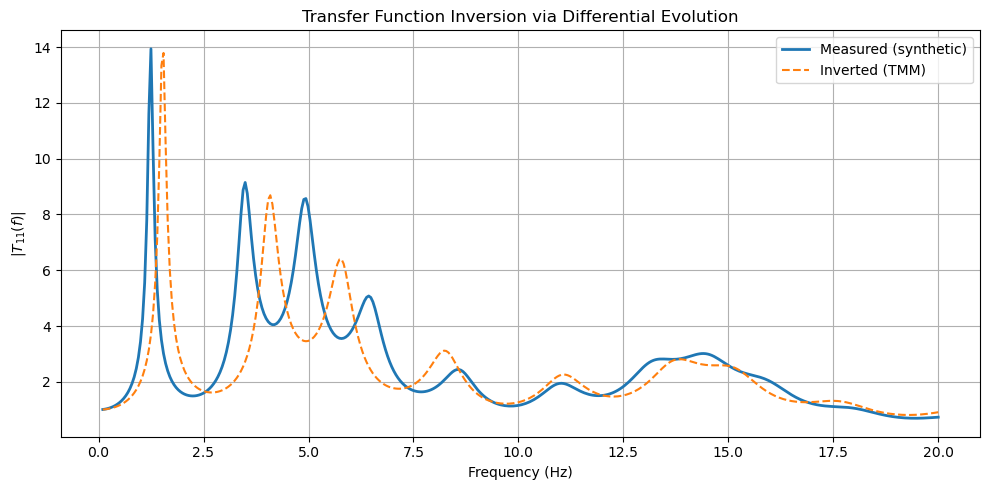

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(freqs, 1/T11_measured, label='Measured (synthetic)', linewidth=2)
plt.plot(freqs, 1/T11_best, label='Inverted (TMM)', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$|T_{11}(f)|$')
plt.title('Transfer Function Inversion via Differential Evolution')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Compare the real profile v. the inverted profile:

Estimated Vs profile (TMM): [120.  168.2 589.5 667.8]
Real Vs profile: [ 120.  190.  280. 1030. 1210.]


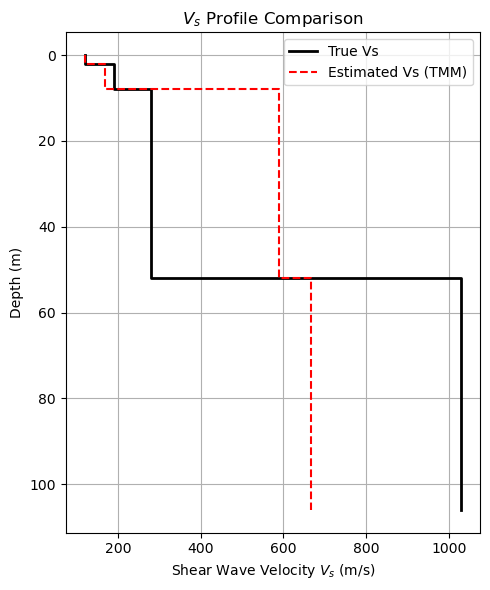

In [13]:
# Print result
print("Estimated Vs profile (TMM):", vs_estimated_TMM.round(1))
print("Real Vs profile:", true_vs.round(1))

true_vs_steps = np.repeat(true_vs[:NN], 2)
est_vs_steps = np.repeat(vs_estimated_TMM[:NN], 2)

# Depth steps (NN interfaces → NN depths + top = NN+1 edges)
depths = np.cumsum(thicknesses)
depth_edges = np.concatenate(([0], depths))
depth_steps = np.repeat(depth_edges, 2)[1:-1]

# Plot
plt.figure(figsize=(5, 6))
plt.plot(true_vs_steps, depth_steps, drawstyle='steps-post', label='True Vs', color='black', linewidth=2)
plt.plot(est_vs_steps, depth_steps, drawstyle='steps-post', label='Estimated Vs (TMM)', linestyle='--', color='red')
plt.gca().invert_yaxis()
plt.xlabel('Shear Wave Velocity $V_s$ (m/s)')
plt.ylabel('Depth (m)')
plt.title('$V_s$ Profile Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Function: `compute_T11_paths(vs_profile, paths_array)`

This function estimates the **frequency-domain surface response** of a layered medium using **path decomposition**, summing over all possible internal paths.

---

### Inputs

- `vs_profile`: Shear wave velocity array for the layers (length = `NN`).
- `paths_array`: Array of shape $(P, NN)$ containing ±1 direction sign paths. Generated with `generate_paths_with_max_reflections()`.

### Output

- A 1D array containing $|T_{11}|$ at each frequency — the **amplitude of the surface motion** relative to the input motion at the base of the profile.


In [14]:
def compute_T11_paths(vs_profile, paths_array):
    # Amplitudes
    ratios = (vs_profile[:NN-1] / vs_profile[1:NN])
    p1 = paths_array[:, :-1]
    p2 = paths_array[:, 1:]
    interface_terms = 0.5 * (1 + p1 * p2 * ratios[np.newaxis, :])
    amplitudes_array = np.prod(interface_terms, axis=1)

    # Delays
    path_delays_array = (paths_array * (thicknesses / vs_profile[:NN])).sum(axis=1)

    # Phase sum
    omega_array = 2 * np.pi * freqs
    phases = np.outer(omega_array, path_delays_array)
    contributions = amplitudes_array * np.cos(phases)

    return contributions.sum(axis=1)

# Precompute all paths
paths_array = generate_paths_with_max_reflections(NN, M=None)


This block repeats the **site‐response inversion** using again **Differential_Evolution** but using path evaluation instead of TMM.

In [15]:
# --- Objective function: only optimize Vs[1:] ---
def objective_function_paths(vs_rest):
    vs_trial = np.concatenate(([known_vs0], vs_rest))
    T11_trial = compute_T11_paths(vs_trial,paths_array)
    return np.sum((T11_trial - T11_measured)**2)

# Re-generate all paths
paths_array = generate_paths_with_max_reflections(NN, 2)

# --- Run Differential Evolution ---
known_vs0 = vs[0]

start = time.time()

result = differential_evolution(objective_function_paths, bounds, maxiter=25, popsize=10, disp=True, polish=False)

end = time.time()

result = differential_evolution(objective_function, bounds, maxiter=20, popsize=10, polish=False)
vs_estimated = np.concatenate(([known_vs0], result.x))

t_inversion_paths = end - start

print(f"Inversion time: {t_inversion_paths:.4f} seconds")

# --- Compare and plot ---
T11_best = compute_T11(vs_estimated)

differential_evolution step 1: f(x)= 77.1205
differential_evolution step 2: f(x)= 77.1205
differential_evolution step 3: f(x)= 77.1205
differential_evolution step 4: f(x)= 77.1205
differential_evolution step 5: f(x)= 77.1205
differential_evolution step 6: f(x)= 67.1092
differential_evolution step 7: f(x)= 61.8349
differential_evolution step 8: f(x)= 61.8349
differential_evolution step 9: f(x)= 61.8349
differential_evolution step 10: f(x)= 61.8349
differential_evolution step 11: f(x)= 61.8349
differential_evolution step 12: f(x)= 61.8349
differential_evolution step 13: f(x)= 61.8349
differential_evolution step 14: f(x)= 61.8349
differential_evolution step 15: f(x)= 51.2974
differential_evolution step 16: f(x)= 51.2974
differential_evolution step 17: f(x)= 51.2974
differential_evolution step 18: f(x)= 51.2974
differential_evolution step 19: f(x)= 40.2595
differential_evolution step 20: f(x)= 40.2595
differential_evolution step 21: f(x)= 40.1677
differential_evolution step 22: f(x)= 40.16

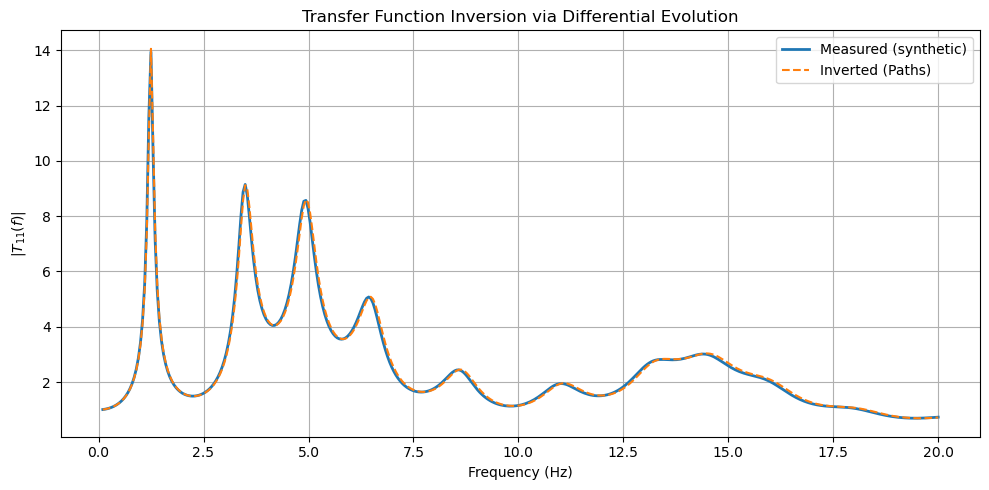

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(freqs, 1/T11_measured, label='Measured (synthetic)', linewidth=2)
plt.plot(freqs, 1/T11_best, label='Inverted (Paths)', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$|T_{11}(f)|$')
plt.title('Transfer Function Inversion via Differential Evolution')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Real Vs profile: [ 120.  190.  280. 1030. 1210.]
Estimated Vs profile (Paths): [ 120.   191.3  281.7 1036.1]
Estimated Vs profile (TMM): [120.         168.24204311 589.50472002 667.76760599]


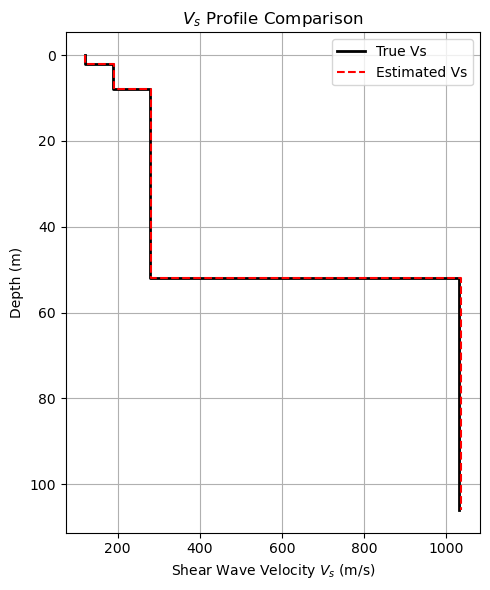

In [17]:
# Print result
print("Real Vs profile:", true_vs.round(1))
print("Estimated Vs profile (Paths):", vs_estimated.round(1))
print("Estimated Vs profile (TMM):", vs_estimated_TMM)

# Use only the NN Vs values (exclude half-space)
true_vs_steps = np.repeat(true_vs[:NN], 2)
est_vs_steps = np.repeat(vs_estimated[:NN], 2)

# Depth steps (NN interfaces → NN depths + top = NN+1 edges)
depths = np.cumsum(thicknesses)
depth_edges = np.concatenate(([0], depths))
depth_steps = np.repeat(depth_edges, 2)[1:-1]

# Plot
plt.figure(figsize=(5, 6))
plt.plot(true_vs_steps, depth_steps, drawstyle='steps-post', label='True Vs', color='black', linewidth=2)
plt.plot(est_vs_steps, depth_steps, drawstyle='steps-post', label='Estimated Vs', linestyle='--', color='red')
plt.gca().invert_yaxis()
plt.xlabel('Shear Wave Velocity $V_s$ (m/s)')
plt.ylabel('Depth (m)')
plt.title('$V_s$ Profile Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Finally, **time comparison**:

In [18]:
print(f"Inversion time TMM: {t_inversion_TMM:.4f} seconds")
print(f"Inversion time Paths: {t_inversion_paths:.4f} seconds")
print(f"Speed-up: {t_inversion_TMM/t_inversion_paths:.0f}x")

Inversion time TMM: 5.3387 seconds
Inversion time Paths: 0.0588 seconds
Speed-up: 91x


# Final Results and Discussion

The inverse modeling results show a **significant performance advantage** when using the **path-based approach** compared to the full **Transfer Matrix Method (TMM)**:

- **Inversion time (TMM)**: 5.3 seconds  
- **Inversion time (Paths, 2 reflections)**: 0.059 seconds  
- **Speed-up**: **~100×**

Even when including all possible paths (i.e., no reflection truncation), the path-based method still achieves a **speed-up of approximately 87×**, demonstrating its efficiency for iterative inversion tasks.

---

### Key Takeaways

- **Accuracy vs. Efficiency Trade-off**: Limiting the number of internal reflections offers a tunable balance between computation time and fidelity to the full-wavefield solution.
- **Path-based inversion** is especially well-suited for applications where fast, approximate solutions are acceptable or desirable (e.g., real-time inversion, sensitivity analyses).

---

### Future Work

Several natural extensions and enhancements can improve realism, generality, and applicability:

1. **Variable Layer Widths and Unknown Layer Count**  
   - Current implementation assumes known and fixed thicknesses and number of layers.  
   - Future work should explore *joint inversion* of both shear velocities and geometric parameters.

2. **Layer-specific Damping and Density**  
   - Present model uses constant damping (`DE`) and fixed density (`rho`).  
   - A more flexible inversion would allow these parameters to vary by layer or be inferred from data.

3. **HVSR Ratio Modeling**  
   - Extending the framework to fit Horizontal-to-Vertical Spectral Ratio (HVSR) curves would allow integration with passive seismic data.  
   - This would enable non-invasive profiling in locations where borehole or active-source data is unavailable.


### System Specifications (for Reproducibility)

- **CPU**: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics  
  - **Architecture**: x86_64  
  - **Logical CPUs**: 16  
  - **NUMA Node**: 0–15

- **RAM**:
  - **Total**: 14 GiB  
  - **Used**: 4.4 GiB  

- **Operating System**: Ubuntu 24.04.2 LTS (Codename: noble)

- **Kernel**: 6.11.0-26-generic

- **Python**: 3.12.3
